In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_pretrained_vit import ViT

In [2]:
# Define a custom dataset for Fashion MNIST
class FashionMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

In [3]:
# Set up data transforms
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

# Load the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [4]:
# Initialize the ViT model
model = ViT('B_16', image_size=28, num_classes=10, pretrained=True)

# Adjust the model's first layer to handle single-channel input
model.patch_embed = nn.Conv2d(1, 768, kernel_size=16, stride=16)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 2, 768])
Loaded pretrained weights.


In [5]:
# Lists to store training and test losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
def train(epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item()}")

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100.0 * correct / total
    train_accuracies.append(train_accuracy)
    print(f"Train Epoch: {epoch}, Loss: {running_loss / len(train_loader)}, Accuracy: {train_accuracy}%")

# Testing loop
def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100.0 * correct / total
    test_accuracies.append(accuracy)
    test_losses.append(test_loss)

    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%\n")

# Training the ViT model
for epoch in range(1, 11):  # Train for 10 epochs as an example
    train(epoch)
    test()

Train Epoch: 1 [0/60000] Loss: 2.3025851249694824
Train Epoch: 1 [6400/60000] Loss: 1.1295843124389648
Train Epoch: 1 [12800/60000] Loss: 0.8325202465057373
Train Epoch: 1 [19200/60000] Loss: 0.731084406375885
Train Epoch: 1 [25600/60000] Loss: 0.9693083763122559
Train Epoch: 1 [32000/60000] Loss: 0.600569486618042
Train Epoch: 1 [38400/60000] Loss: 0.7548533082008362
Train Epoch: 1 [44800/60000] Loss: 0.7690801024436951
Train Epoch: 1 [51200/60000] Loss: 0.5450655817985535
Train Epoch: 1 [57600/60000] Loss: 0.8619308471679688
Train Epoch: 1, Loss: 0.820198545450849, Accuracy: 69.79666666666667%

Test set: Average loss: 0.6566, Accuracy: 76.72%

Train Epoch: 2 [0/60000] Loss: 0.5712202787399292
Train Epoch: 2 [6400/60000] Loss: 0.5243696570396423
Train Epoch: 2 [12800/60000] Loss: 0.572600781917572
Train Epoch: 2 [19200/60000] Loss: 0.5638028979301453
Train Epoch: 2 [25600/60000] Loss: 0.37207040190696716
Train Epoch: 2 [32000/60000] Loss: 0.6026357412338257
Train Epoch: 2 [38400/60000

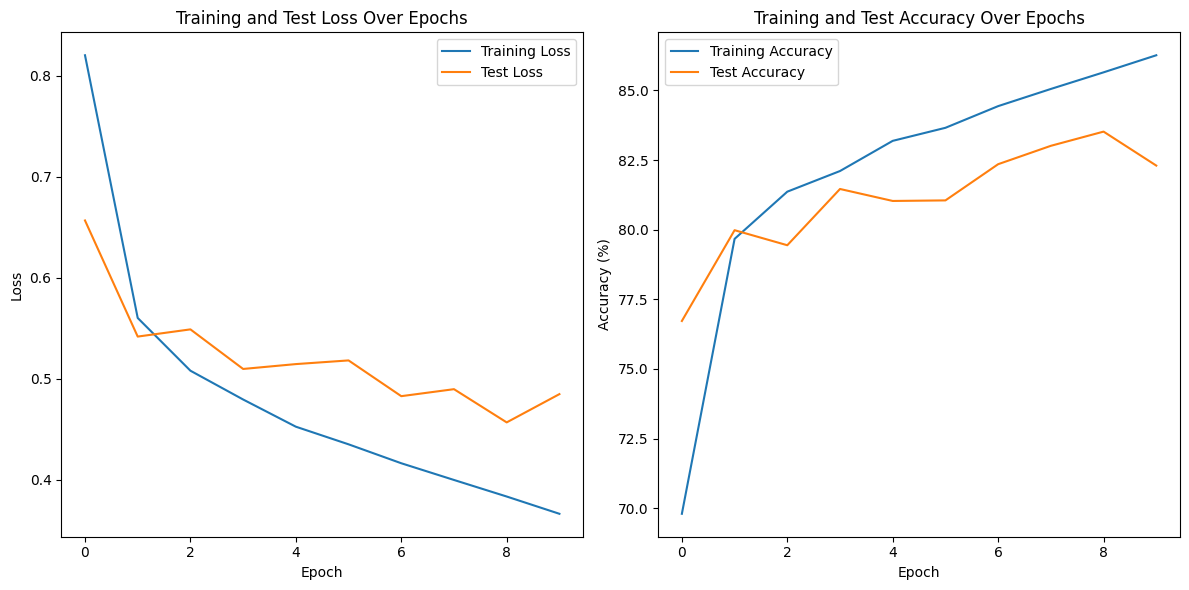

In [6]:
# Plot the training and test losses and accuracies together
plt.figure(figsize=(12, 6))

# Plot training and test losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Test Loss Over Epochs")

# Plot training and test accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Test Accuracy Over Epochs")

plt.tight_layout()
plt.show()

In [7]:
print(train_losses)

[0.820198545450849, 0.5601164358638243, 0.5079017179066947, 0.4793862753998496, 0.4524717393841571, 0.4350208071535076, 0.41627787932086346, 0.39973650370706626, 0.38334018203304776, 0.3662391984100535]


In [8]:
print(test_losses)

[0.6566401862414779, 0.5416839658075078, 0.5488211840960631, 0.5096346644838904, 0.5144477630876432, 0.5180848756223727, 0.4826954607940783, 0.4896186670869779, 0.45673005197458205, 0.48471301224581]


In [9]:
print(train_accuracies)

[69.79666666666667, 79.66833333333334, 81.36333333333333, 82.105, 83.18833333333333, 83.65666666666667, 84.435, 85.05166666666666, 85.64833333333333, 86.26166666666667]


In [10]:
print(test_accuracies)

[76.72, 79.98, 79.44, 81.46, 81.03, 81.05, 82.35, 83.01, 83.52, 82.3]
